In this lab we are going to try to isolate breathing data from 3-lead ECG signals. We are also going to compare the data quality when user is performing different activities

First we are going to try it on a signal obtained the test subject was being stationary.

In [1]:
# Scientific packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, spectrogram, butter, filtfilt, find_peaks
from scipy.fft import  rfft, rfftfreq
from process import process

Step 1: Load the signal

In [2]:
# Sampling frequency of acquired data
fs = 200 #200Hz

# TODO: load ECG signal using genfromtxt()
signal = np.genfromtxt('data/ECG_static.csv')

# TODO: Generate the time axis of the signal given its sampling frequency
# hint: length of time and signal should be the same, each 2 timestamps differ by 1/fs
# make sure to convert it to numpy array
length = len(signal)
period = 1/fs
total_time = length * period
time = np.arange(0, total_time, period)

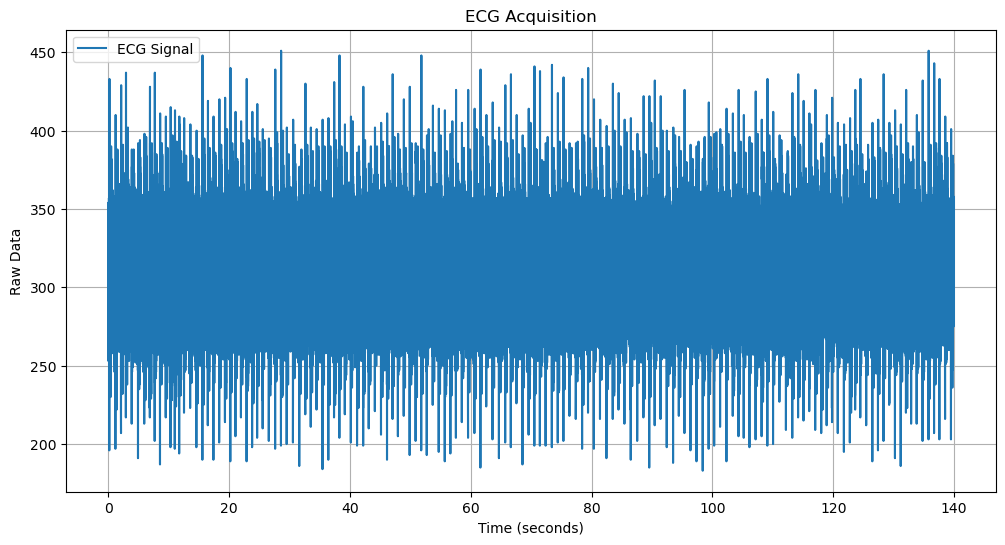

In [3]:
## Visualize the raw data
plt.figure(figsize=(12, 6))
plt.plot(time[1:], signal, label='ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Raw Data')
plt.title('ECG Acquisition')
plt.legend()
plt.grid(True)
plt.show()

In this lab we will utilize different filters to get breathing rate from ECG signals. Please refer back to Module 3 lesson 6 of the lecture for a refresher on different filters.

We will first use moving average & Sav-Gol filters to smooth out the data

**Step 2: Apply moving average filter**

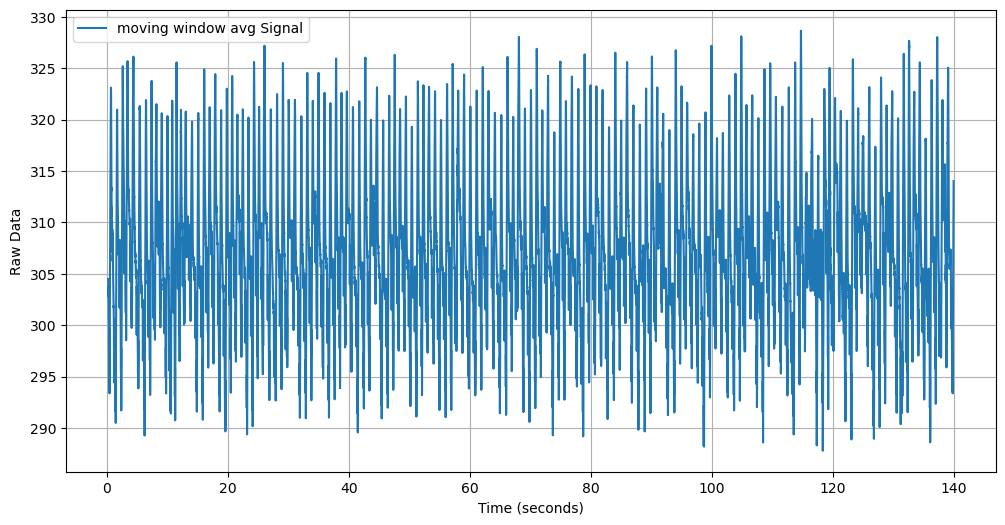

In [4]:
## Apply moving window averaging & Savitzky–Golay filter
def moving_average(signal, window_size):
    cumsum = np.cumsum(np.insert(signal, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

# TODO: apply moving window averaging with an arbitrary window size, np.mean could be helpful
mov_avg_sig = moving_average(signal, window_size=50)

# TODO: update the timestamp to indicate the center of the moving average window
time = time[len(time) - len(mov_avg_sig):]

# to visualize the effect
plt.figure(figsize=(12, 6))
plt.plot(time, mov_avg_sig, label='moving window avg Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Raw Data')
plt.legend()
plt.grid(True)
plt.show()

**Step 3: Apply Savitzky-Golay filter**

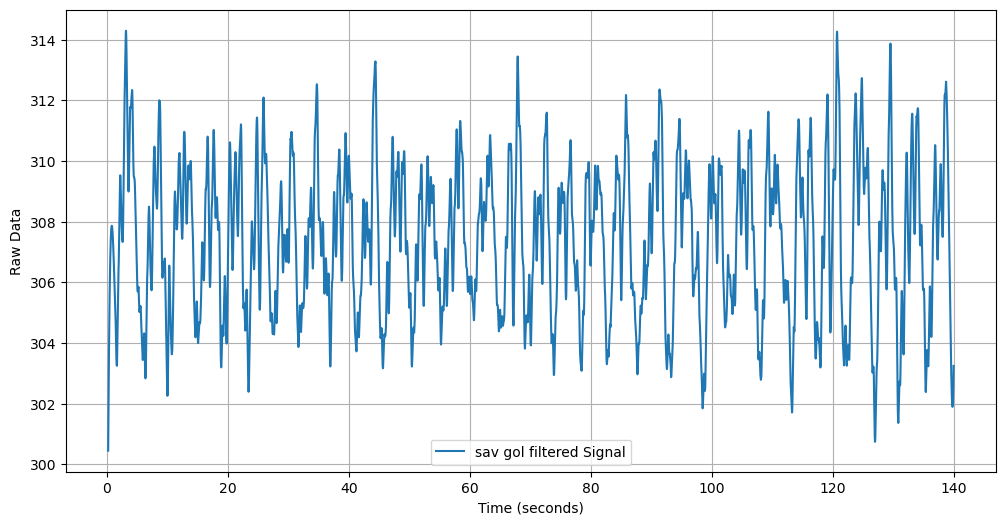

In [5]:

# TODO: apply sav-gol filter using function savgol_filter() from scipy.signal
savgol_signal = savgol_filter(mov_avg_sig, window_length=500, polyorder=4)

# to visualize the effect
plt.figure(figsize=(12, 6))
plt.plot(time, savgol_signal, label='sav gol filtered Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Raw Data')
plt.legend()
plt.grid(True)
plt.show()

Then we will apply a low-pass filter to only preserve breathing data. Make sure to fine tune the cut-off frequency properly

**Step 4: Apply low-pass filter**

In [6]:
## Apply low pass filter to filter out actual ECG signal
def lowpass(signal, fs, cutoff):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal
# TODO: Implement the low-pass filter using lowpass() in biosignalsnotebook.process
filtered_signal = lowpass(savgol_signal, fs, cutoff=0.5)

You might notice a spike/drop at the beginning of the data plot, which is the artifact created by the filter. To prevent it from messing up our analysis, clip the first several seconds off of the data

In [7]:
# clip first 5 seconds of data
time = time[1000:]
filtered_signal = filtered_signal[1000:]

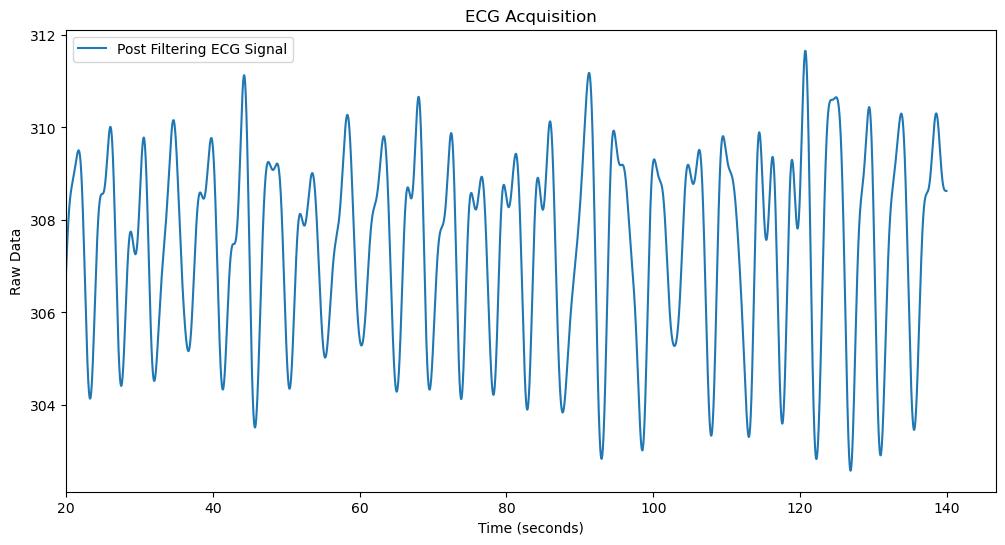

In [8]:
# Plotting the filtered ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time, filtered_signal, label='Post Filtering ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Raw Data')
plt.title('ECG Acquisition')
plt.legend()
plt.xlim(left = 20)
plt.show()

# See if you can count and calculate the breathing rate by looking at the plot

Now we need to normalize the data to eliminate a DC component that has a frequency of 0. This step is a stepping stone for the spectrogram analysis

**Step 5: Data normalization**

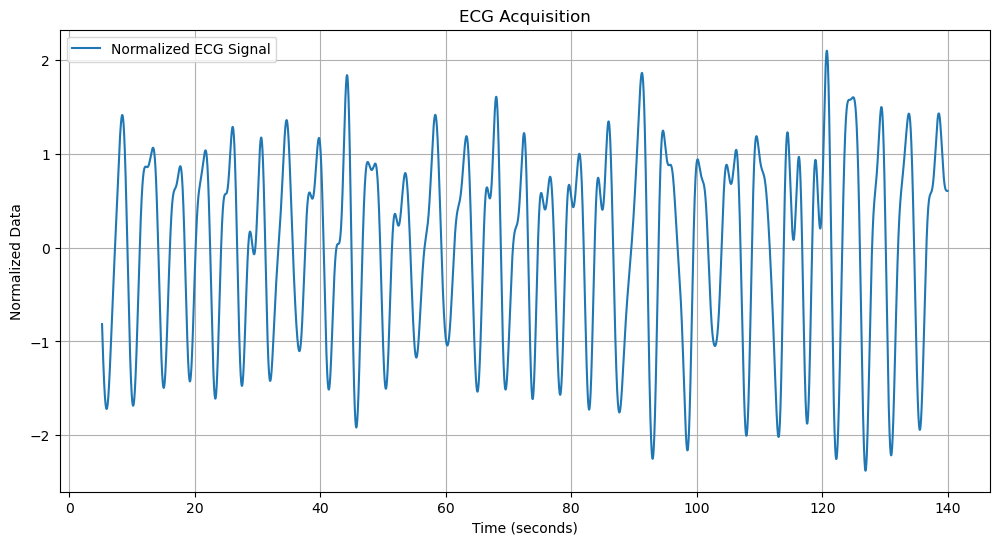

In [9]:
## normalize breathing data

# TODO: Normalize data with mean & std
norm_signal = filtered_signal - np.mean(filtered_signal)
norm_signal = norm_signal / np.std(norm_signal)

#plot
plt.figure(figsize=(12, 6))
plt.plot(time, norm_signal, label='Normalized ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Data')
plt.title('ECG Acquisition')
plt.legend()
plt.grid(True)
plt.show()

Now we are going to (effectively) perform a Fourier analysis to get the dominant frequencies of the breathing rate data.

**Step 6: Perform spectrogram analysis**

First, we are going to generate a spectrogram to visualize the range of dominant frequencies in the data

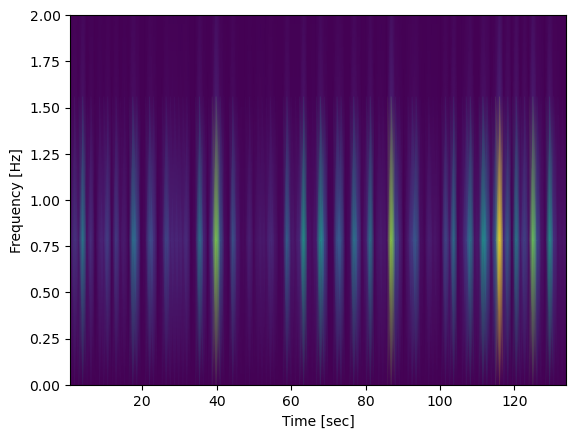

In [10]:
# plot spectrogram to visualize dominant frequency

np_norm_signal = np.array(norm_signal)

f, t, Sxx = spectrogram(np_norm_signal, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0,2])
plt.show()

Next, we are going to apply Fourier transform and find the most dominant frequency in this data, and treat that frequency as the breathing rate.
Please refer back to Module 3 Lesson 4 for a refresher on fourier transform

**Step 7: Perform Fourier Transform**

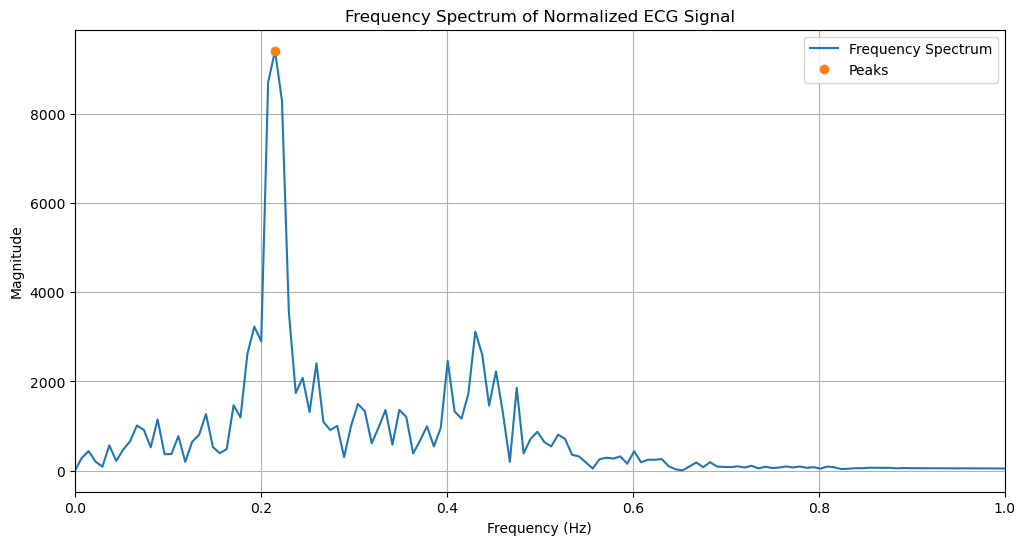

In [11]:
## Find breathing rate

# TODO: Compute the Fourier Transform of the filtered signal using rfft() from scipy.fft
fft_vals = rfft(norm_signal)

# TODO: Compute all frequencies present in the signal using rfftfreq() from scipy.fft
fft_freq = rfftfreq(len(norm_signal), 1/fs)

# find peaks and plot
peaks = find_peaks(np.abs(fft_vals), height=3000, distance=100)[0]

# TODO: Plot frequency distribution of breathing data
plt.figure(figsize=(12, 6))
plt.plot(fft_freq, np.abs(fft_vals), label='Frequency Spectrum')
plt.plot(fft_freq[peaks], np.abs(fft_vals)[peaks], 'o', label='Peaks')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of Normalized ECG Signal')
plt.xlim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

**Step 8: Calculate breathing rate**


In [12]:
# TODO: Find the dominant frequency
# The dominant frequency is the one with the highest magnitude in the spectrum, which is assumed to be related to the respiratory rate

dominant_frequency = fft_freq[peaks[0]]
print(f"Dominant Frequency: {dominant_frequency:.4f} Hz")

# Convert to breaths per minute
breath_rate = dominant_frequency * 60

print(f"Estimated Breath Rate: {breath_rate:.2f} breaths per minute")

Dominant Frequency: 0.2153 Hz
Estimated Breath Rate: 12.92 breaths per minute


**Step 9: Process an alternative scenario**

Now that you know the drill, repeat the same process using ECG obtained under a different scenario. Find the breathing rate of that data, and comment on what you did differently to get the results.

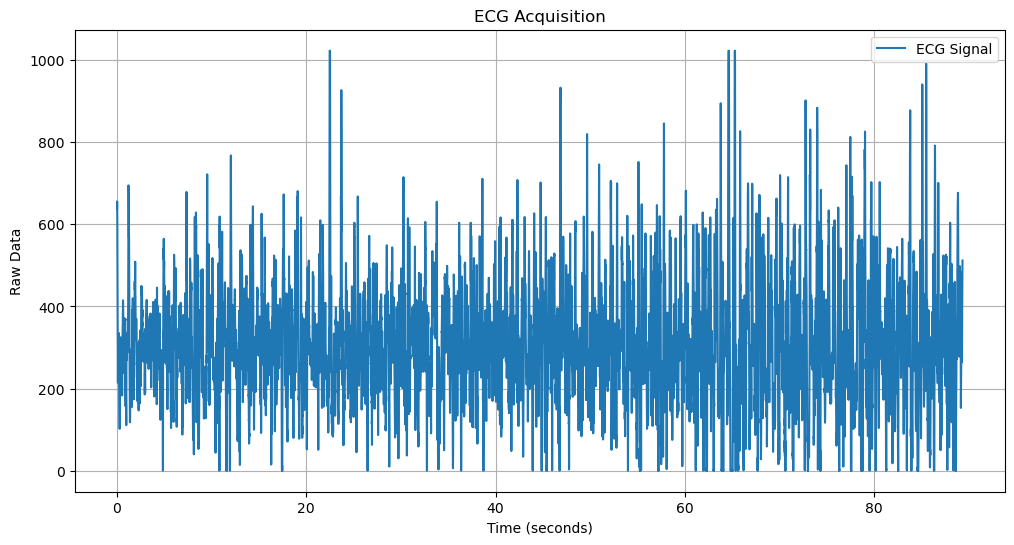

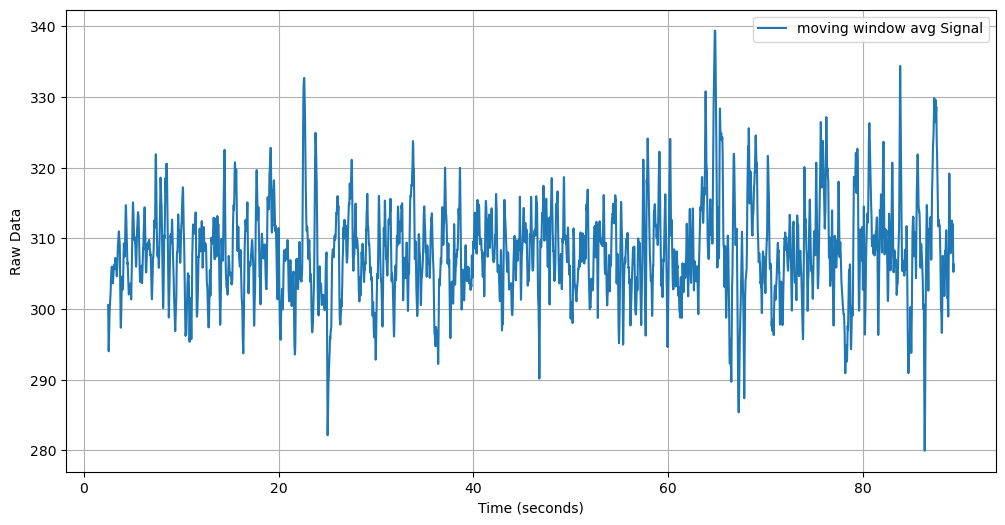

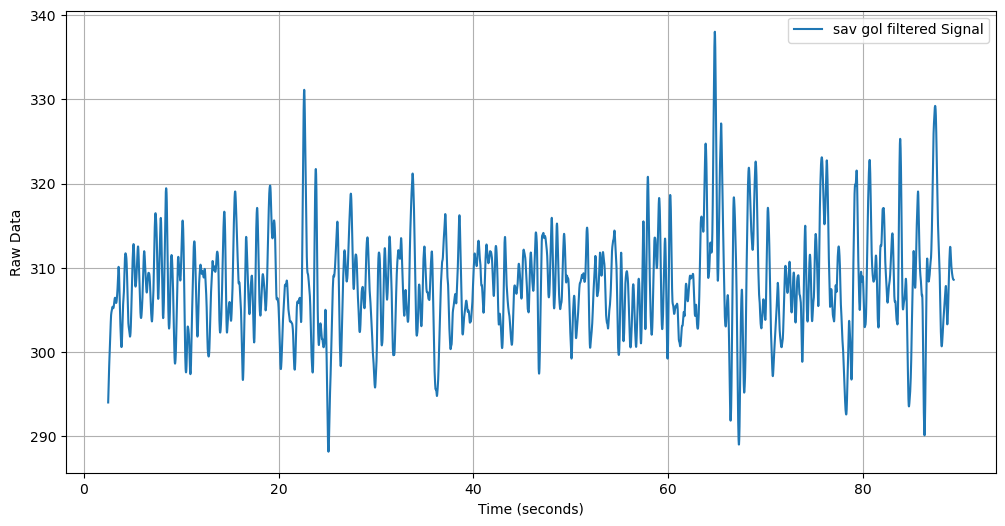

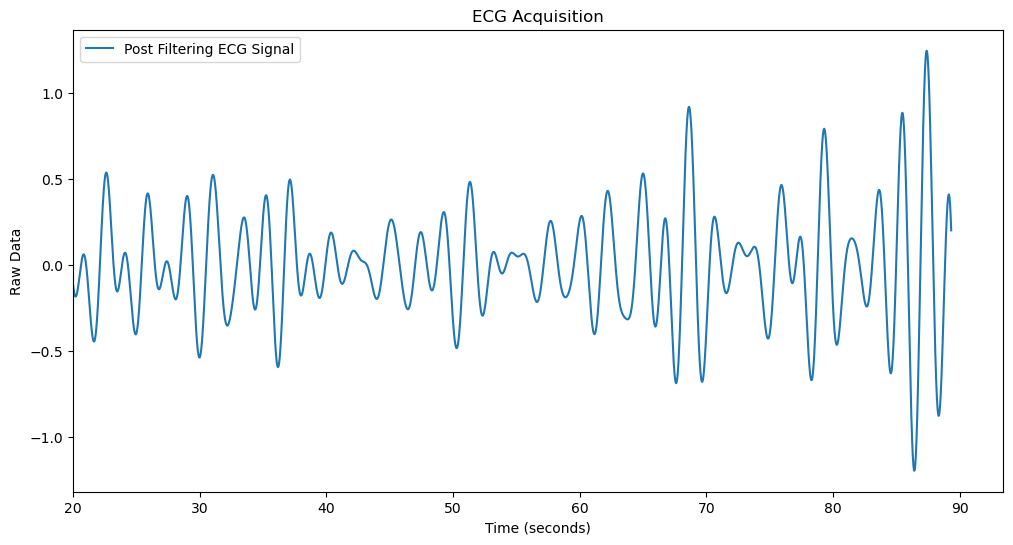

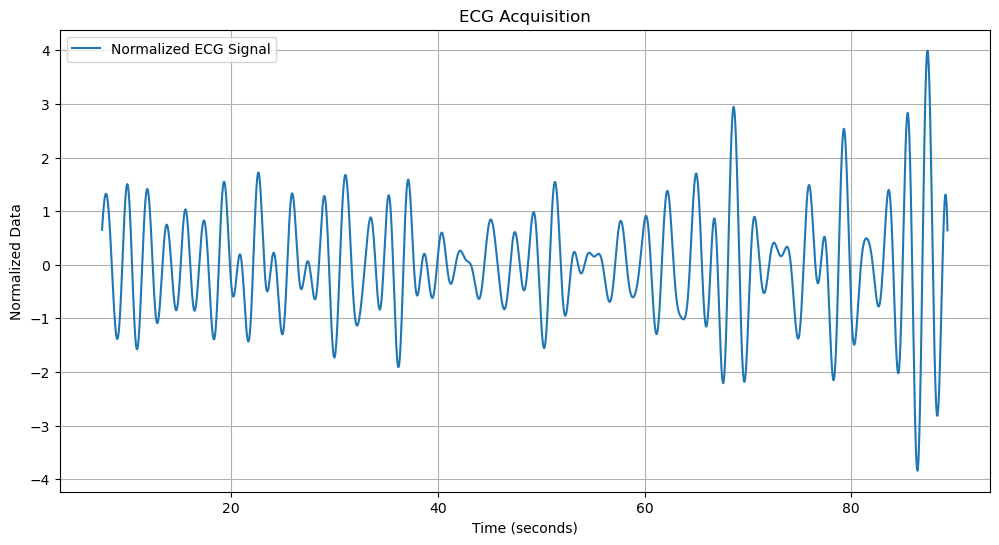

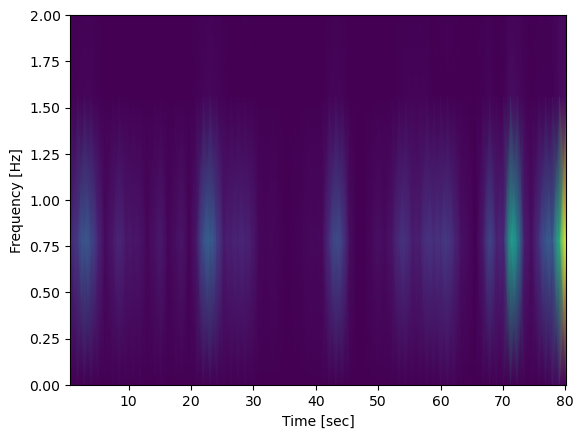

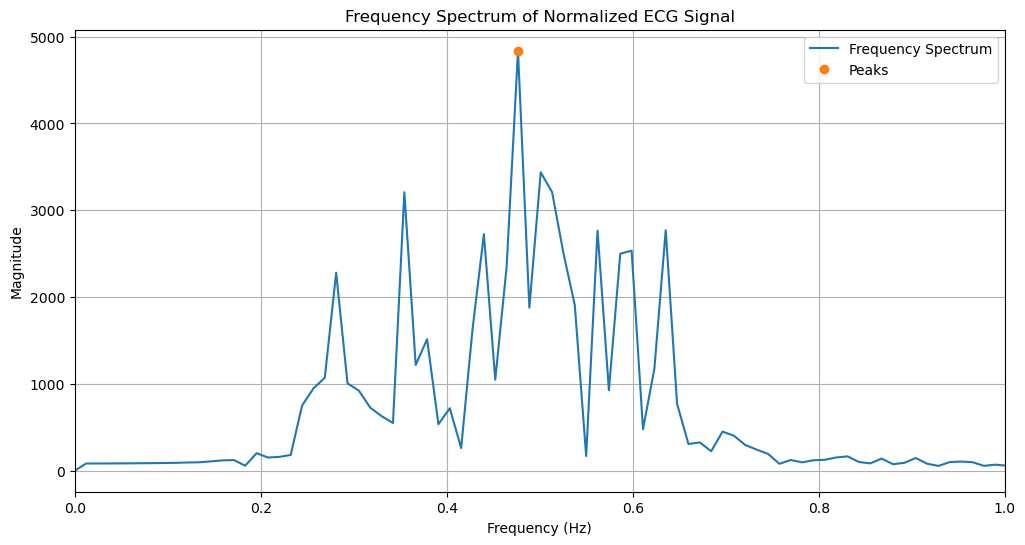

Dominant Frequency: 0.4766 Hz
Breath Rate: 28.59 breaths per minute


In [13]:
process('data/ECG_walking.csv', 3500, 10, 500, 100, 2, 0.42, 0.4)

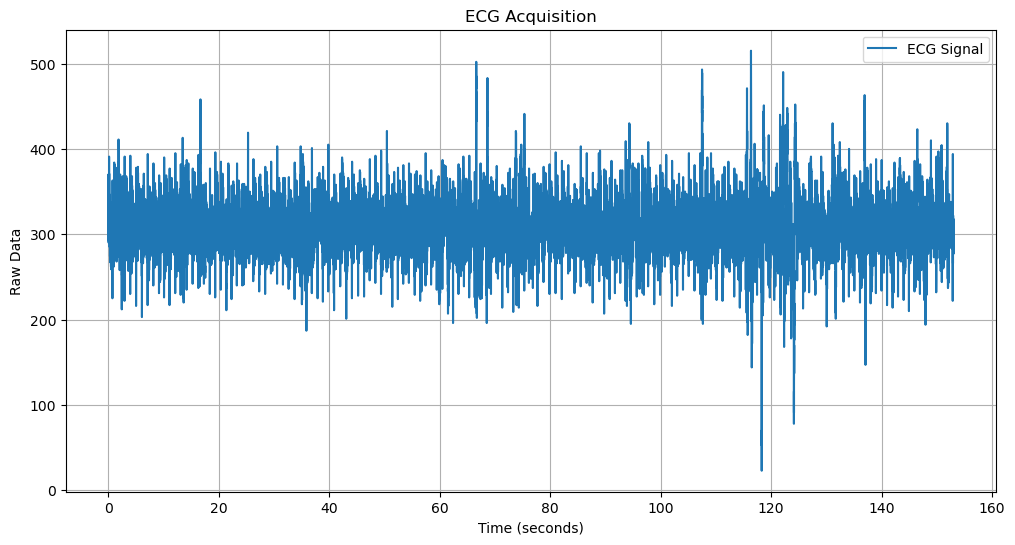

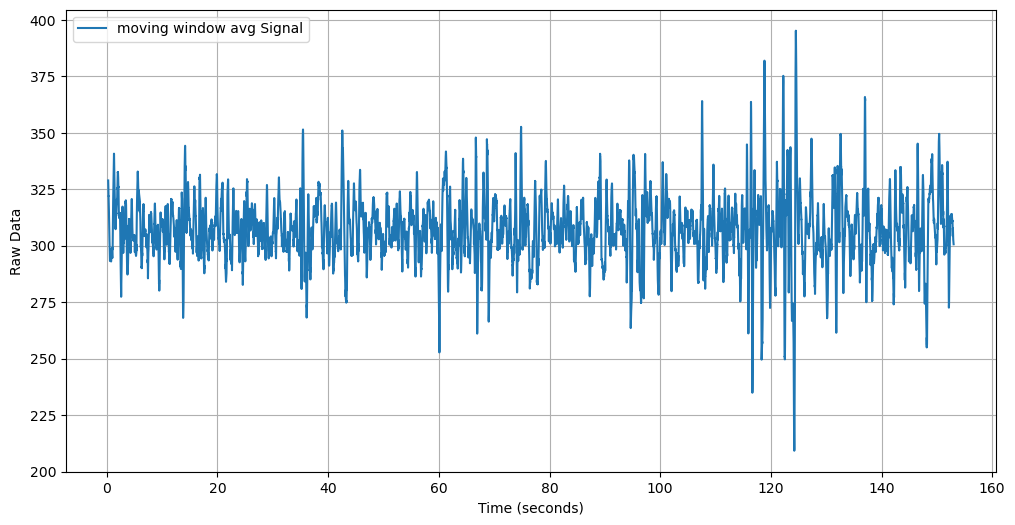

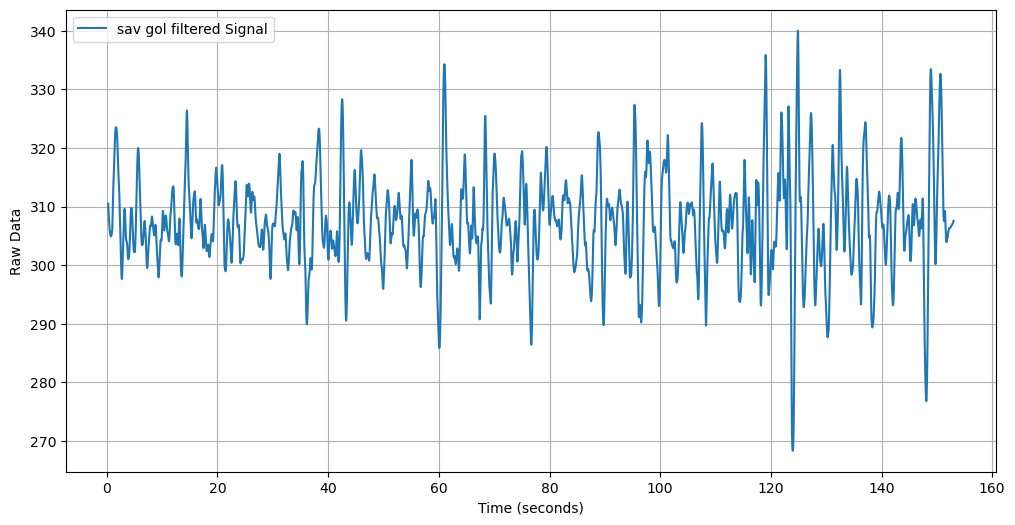

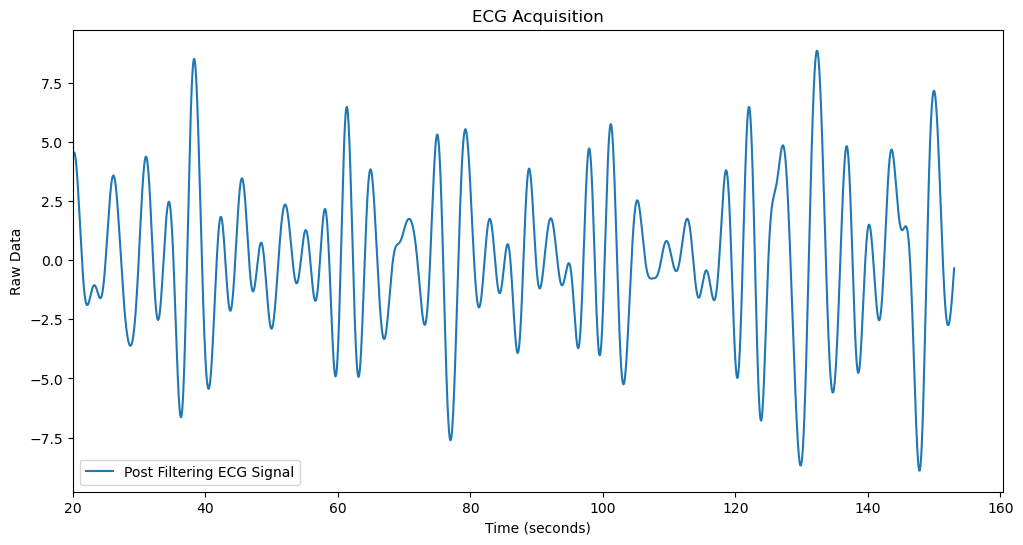

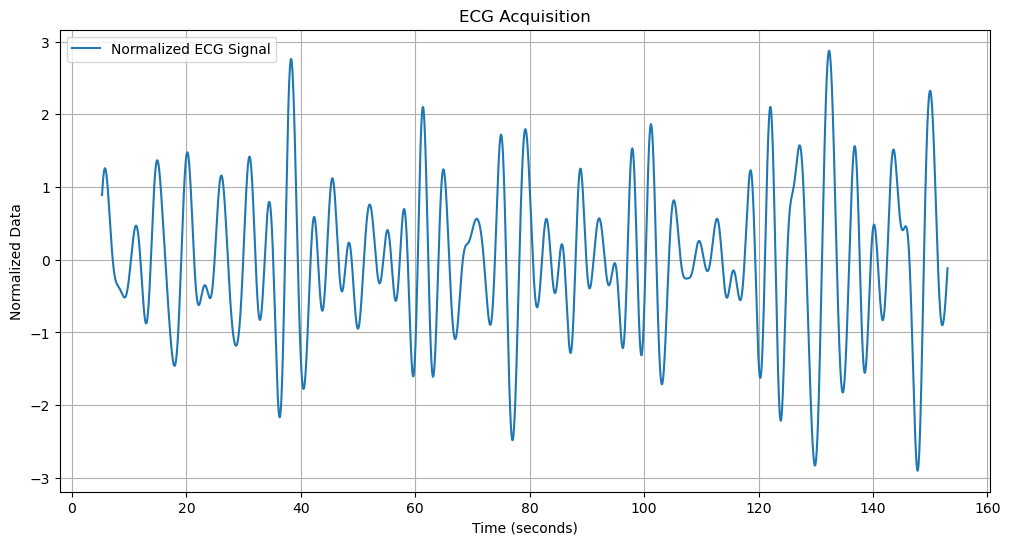

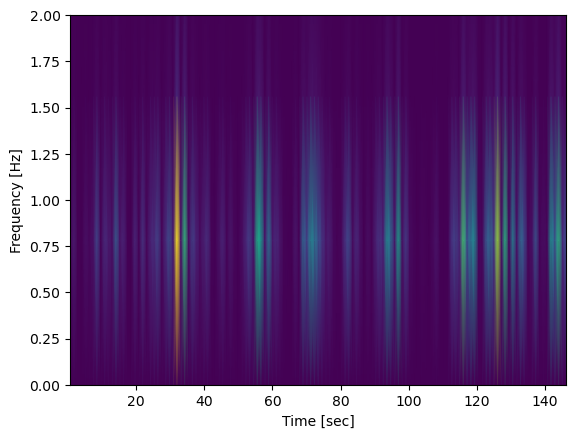

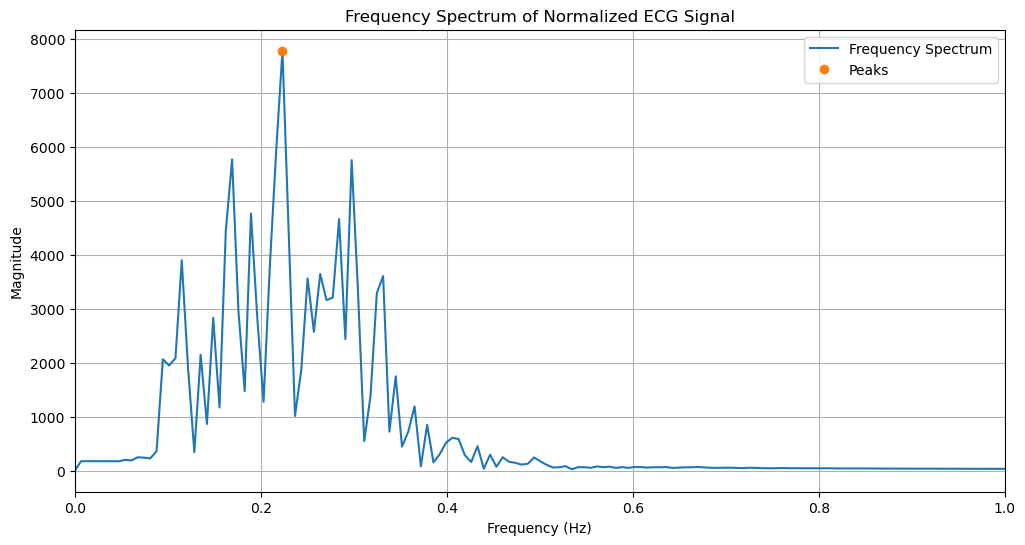

Dominant Frequency: 0.2233 Hz
Breath Rate: 13.40 breaths per minute


In [14]:
process('data/ECG_typing.csv', 2000, 100, 50, 300, 2, 0.3)

**Step 10: Discussion**

Finally, compile a report showcasing everything you have done. Remember to talk about the parameters you chose for filters and your rationale for choosing specific values for different data. (Hint: you should at least talk about the window size for moving average & Sav-gol filters, as well as the cut-off frequency for low-pass filter)